Task 1: Data Filtering

In [1]:
%pip install "dask[dataframe]" pandas langdetect

# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.8 MB/s  0:00:01 14.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

In [30]:
# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

print(f"\nShape of Dataset: ", df.shape)
display(f"Dataframe's head: ", df.head())

Loading data from ../../data/filtered_reviews.csv...
Loaded 193166 reviews.

Shape of Dataset:  (193166, 12)


"Dataframe's head: "

,game,author_num_games_owned,author_num_reviews,author_playtime_at_review,language,review,voted_up,votes_funny,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,Counter-Strike,41.0,10.0,221.0,english,cs 1.6>cs2,1,13.0,0.863652,1,0,0
1,Counter-Strike,0.0,1.0,396410.0,english,#1 PLAYED PC GAME ONLINE SINCE 1999,1,1.0,0.865922,1,0,0
2,Counter-Strike,50.0,50.0,81.0,english,"best played with a membrane keyboard, a roller...",1,31.0,0.935513,1,0,0
3,Counter-Strike,11.0,5.0,78.0,english,My friend who I play counter-strike with said ...,1,19.0,0.875650,1,0,0
4,Counter-Strike,0.0,27.0,26568.0,english,Counter-Strike won't ever be canceled. Counter...,1,2.0,0.877432,1,0,0


In [5]:
# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

In [6]:
print("Starting text preprocessing")

# Apply the function to the 'review' column
# df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")
# Save Output
# Save the dataset with the new 'cleaned_review' column
# df.to_csv(OUTPUT_FILE, index=False)
# print(f"Saved processed data to {OUTPUT_FILE}")

Starting text preprocessing
Preprocessing complete!


In [7]:
df = pd.read_csv(OUTPUT_FILE)
df['cleaned_review'] = df['cleaned_review'].fillna('')

Generating Word Cloud...


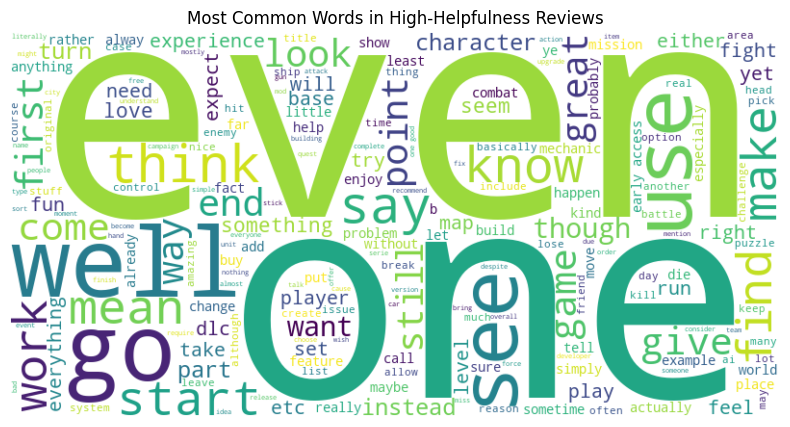

In [8]:
# 3. Word Cloud
print("Generating Word Cloud...")
all_text = " ".join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in High-Helpfulness Reviews')
plt.show()

Generating Frequency Plot...


/var/folders/gp/cdw2kmg51lj5xg8c7ztndxf00000gn/T/ipykernel_35706/3365029400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


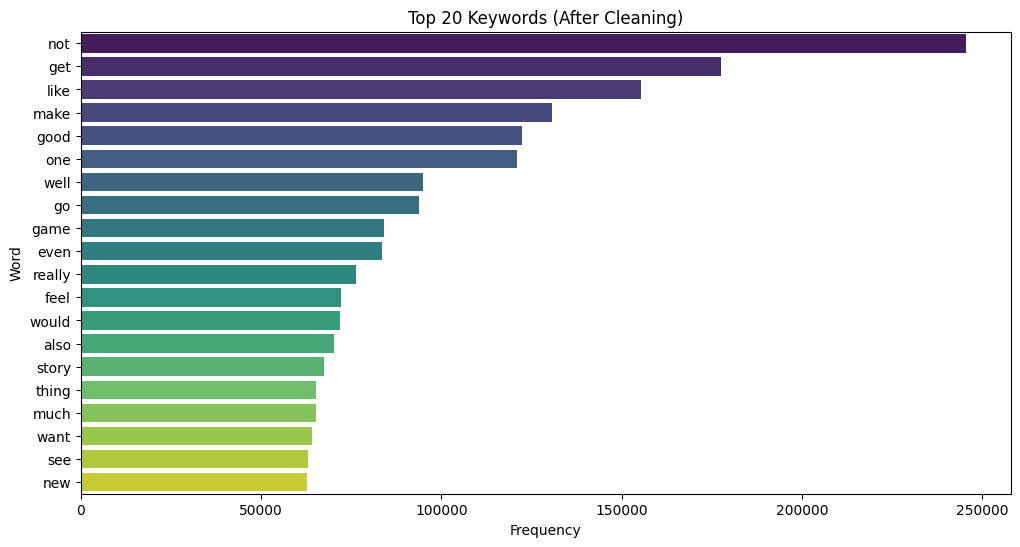

In [9]:
# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

Generating Correlation Heatmap...


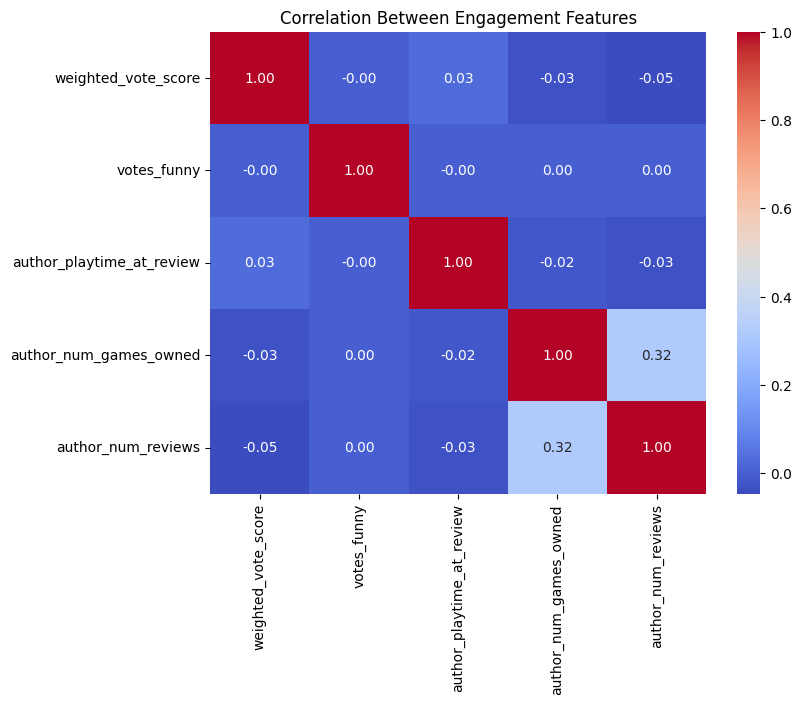

In [10]:
# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()

In [11]:
# 6. Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Saved processed data to ../../data/processed_text.csv


In [12]:
features = ['author_playtime_at_review', 'author_num_games_owned', 'author_num_reviews', 'votes_funny', 'weighted_vote_score']

target = 'voted_up'
df[target] = df[target].astype(int)

X = df[features]
y = df[target]

In [13]:
# imputer to handle missing data
imp = SimpleImputer(strategy='mean')
X_imp = imp.fit_transform(X)

# scale data for logistical regression
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_imp)

In [14]:
# train data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=0)

In [15]:
# initialize the simple models
knn = KNeighborsClassifier(n_neighbors=5)
logmodel = LogisticRegression(random_state=0)
decisiontree = DecisionTreeClassifier(random_state=0)

In [16]:
# train models
print("Training Logistic Regression Model:")
logmodel.fit(X_train, y_train)
y_pred_log = logmodel.predict(X_test)
print("Training Decision Tree Model:")
decisiontree.fit(X_train, y_train)
y_pred_dt = decisiontree.predict(X_test)
print("Training KNN:")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Training Logistic Regression Model:
Training Decision Tree Model:
Training KNN:


In [17]:
# display results
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")
print(f"Precision: {precision_score(y_test, y_pred_log)}")
print(f"Recall: {recall_score(y_test, y_pred_log)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log)}")
print("")
print("Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt)}")
print("")
print("KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precision: {precision_score(y_test, y_pred_knn)}")
print(f"Recall: {recall_score(y_test, y_pred_knn)}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn)}")

Logistic Regression:
Accuracy: 0.8100119066107574
Precision: 0.8100119066107574
Recall: 1.0
F1 Score: 0.8950348930328338

Decision Tree:
Accuracy: 0.7102293316767614
Precision: 0.8279541820317854
Recall: 0.810730491468013
F1 Score: 0.8192518203981465

KNN:
Accuracy: 0.7777864057565874
Precision: 0.8137729018708376
Recall: 0.941011056432543
F1 Score: 0.8727790044605148


In [18]:
print(df['voted_up'].value_counts(normalize=True))
print("This shows that logistic regression just guessed 'positive' for all of the reviews.")

voted_up
1    0.807306
0    0.192694
Name: proportion, dtype: float64
This shows that logistic regression just guessed 'positive' for all of the reviews.


In [19]:
# the more advanced models
X_adv = df[numeric_cols + ['cleaned_review']]
y_adv = df['voted_up'].astype(int)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_adv, y_adv, test_size=0.2, random_state=0)

In [21]:
# numerical transformer
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

# converts text into numerical vectors
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
preproc = ColumnTransformer(transformers=[('num', numerical_transformer, numeric_cols), ('txt', text_transformer, 'cleaned_review')])

In [22]:
# random forest
print("Training Random Forest: ")
randomforest = Pipeline(steps=[('preprocessor', preproc), ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state = 0, n_jobs = 1))])
randomforest.fit(X_train, y_train)
y_pred_randomforest = randomforest.predict(X_test)
print("")
print("Random Forest: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_randomforest)}")
print(f"Precision: {precision_score(y_test, y_pred_randomforest)}")
print(f"Recall:    {recall_score(y_test, y_pred_randomforest)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_randomforest)}")

Training Random Forest: 

Random Forest: 
Accuracy:  0.8698555676347259
Precision: 0.8717237475233512
Recall:    0.9841503163545727
F1 Score:  0.9245317002881844


In [23]:
# gradient boosting

print("Training Gradient Boosting: ")
gradientboosting = Pipeline(steps=[('preprocessor', preproc), ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0))])
gradientboosting.fit(X_train, y_train)
y_pred_gradientboosting = gradientboosting.predict(X_test)
print("")
print("Gradient Boosting: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gradientboosting)}")
print(f"Precision: {precision_score(y_test, y_pred_gradientboosting)}")
print(f"Recall:    {recall_score(y_test, y_pred_gradientboosting)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_gradientboosting)}")

Training Gradient Boosting: 

Gradient Boosting: 
Accuracy:  0.8534192680022777
Precision: 0.8546365221241387
Recall:    0.9868984469866428
F1 Score:  0.9160178552891104


In [24]:
# adaboost
adaboost = Pipeline(steps=[('preprocessor', preproc), ('classifier', AdaBoostClassifier(n_estimators=50, random_state=0))])
print("Training AdaBoost: ")
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)
print("")
print("Ada Boosting: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_adaboost)}")
print(f"Precision: {precision_score(y_test, y_pred_adaboost)}")
print(f"Recall:    {recall_score(y_test, y_pred_adaboost)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_adaboost)}")

Training AdaBoost: 

Ada Boosting: 
Accuracy:  0.8225914997152767
Precision: 0.8249481465723555
Recall:    0.9913401930082444
F1 Score:  0.900522496371553


In [25]:
# support vector machine
svm_model = Pipeline(steps=[('preprocessor', preproc), ('classifier', LinearSVC(C=1.0, random_state=0, dual='auto'))])
print("Training Linear SVM: ")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("")
print("Linear SVM: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_svm)}")
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall:    {recall_score(y_test, y_pred_svm)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_svm)}")

Training Linear SVM: 

Linear SVM: 
Accuracy:  0.8973701920588083
Precision: 0.9164863299704349
Recall:    0.9608551159966767
F1 Score:  0.9381464206043398


In [26]:
# neural network
nn= Pipeline(steps=[('preprocessor', preproc), ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0))])
print("Training Neural Network: ")
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("")
print("Neural Network: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nn)}")
print(f"Precision: {precision_score(y_test, y_pred_nn)}")
print(f"Recall:    {recall_score(y_test, y_pred_nn)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_nn)}")

Training Neural Network: 

Neural Network: 
Accuracy:  0.8900968059222446
Precision: 0.9232333980096389
Recall:    0.9427046718220745
F1 Score:  0.9328674424487731
